<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1">Загрузка данных</a></span></li><li><span><a href="#Предобработка-и-анализ-данных" data-toc-modified-id="Предобработка-и-анализ-данных-2">Предобработка и анализ данных</a></span></li><li><span><a href="#Построение-базовой-нейронной-сети" data-toc-modified-id="Построение-базовой-нейронной-сети-3">Построение базовой нейронной сети</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.0.1">Вывод:</a></span></li></ul></li></ul></li><li><span><a href="#Улучшение-нейронной-сети" data-toc-modified-id="Улучшение-нейронной-сети-4">Улучшение нейронной сети</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5">Выводы</a></span></li></ul></div>

## Загрузка данных

In [122]:
pip install skorch

     |████████████████████████████████| 239 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [123]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import itertools
from torch.utils.data import DataLoader, TensorDataset
from math import ceil
import seaborn as sns
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

In [42]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [43]:
try:
    df = pd.read_csv('/datasets/6_class.csv', index_col = 0)
except:
    print('При загрузке файла возникла ошибка')

In [44]:
df.to_csv('6_class.csv', index=False)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [46]:
df.head()

Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
0             3068          0.002400        0.1700                   16.12   
1             3042          0.000500        0.1542                   16.60   
2             2600          0.000300        0.1020                   18.70   
3             2800          0.000200        0.1600                   16.65   
4             1939          0.000138        0.1030                   20.06   

   Star type Star color  
0          0        Red  
1          0        Red  
2          0        Red  
3          0        Red  
4          0        Red

Вывод:
 - наименование столбцов необходимо привести к стандартному наименованию
 - пропусков нет

## Предобработка и анализ данных

Переименуем столбцы

In [47]:
df.rename(columns={
    'Temperature (K)':'temperature',
    'Luminosity(L/Lo)':'luminosity',
    'Radius(R/Ro)':'radius',
    'Absolute magnitude(Mv)':'magnitude',
    'Star type':'star_type',
    'Star color':'color'
}, inplace=True)

In [48]:
df.head()

temperature  luminosity  radius  magnitude  star_type color
0         3068    0.002400  0.1700      16.12          0   Red
1         3042    0.000500  0.1542      16.60          0   Red
2         2600    0.000300  0.1020      18.70          0   Red
3         2800    0.000200  0.1600      16.65          0   Red
4         1939    0.000138  0.1030      20.06          0   Red

Проверим количественные признаки

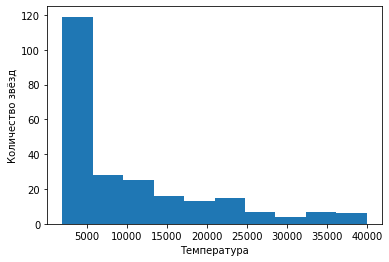

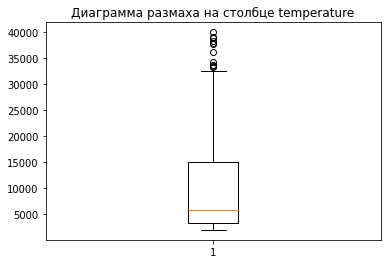

In [49]:
plt.hist(df['temperature'])
plt.xlabel('Температура')
plt.ylabel('Количество звёзд')
plt.show()

plt.boxplot(df['temperature'])
plt.title('Диаграмма размаха на столбце temperature')
plt.show()

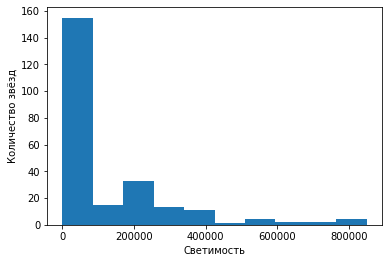

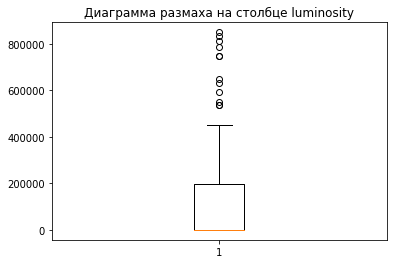

In [50]:
plt.hist(df['luminosity'])
plt.xlabel('Светимость')
plt.ylabel('Количество звёзд')
plt.show()


plt.boxplot(df['luminosity'])
plt.title('Диаграмма размаха на столбце luminosity')
plt.show()

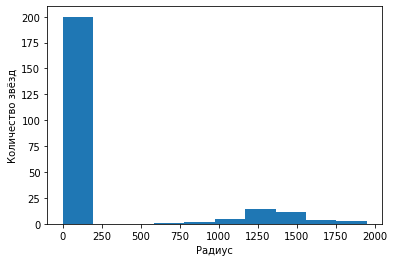

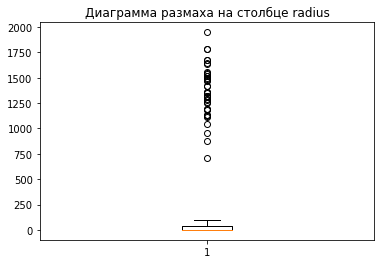

In [51]:
plt.hist(df['radius'])
plt.xlabel('Радиус')
plt.ylabel('Количество звёзд')
plt.show()

plt.boxplot(df['radius'])
plt.title('Диаграмма размаха на столбце radius')
plt.show()

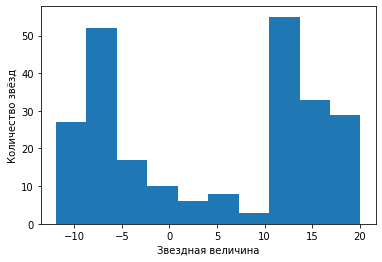

In [52]:
plt.hist(df['magnitude'])
plt.xlabel('Звездная величина')
plt.ylabel('Количество звёзд')
plt.show()

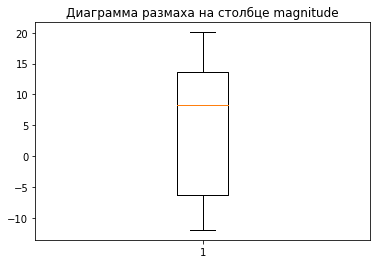

In [53]:
plt.boxplot(df['magnitude'])
plt.title('Диаграмма размаха на столбце magnitude')
plt.show()

Выводы
- Temperature - медианное значение находится в районе 5000(К), на графике боксплот видны выбросы. после значения 32000(К) Это звёзды с очень высокой температурой, значительно отличающейся от большинства данных в выборке. При этом, исключить эти звезды мы не можем, потому что в действительности такие тепературы могут быть, и этот признак является целевым.
- Lumocity - большинство звёзд  имеют очень маленькую светимость, т.к. медианное значение близко к нулю. Наблюдаются выбросы после значения 400000, но это не противоречит возможным физическим свойствам звезд.
- Radius -  графики очень похожи на предыдущие, основное количество сосредоточено возле минимальных значений, при этом наблюдается большой хвост выбросов на больших значения, что однако не противоречит возможным физическим характеристиками.
- Magnitude - этот признак без выбросов. Распределение имеет два выраженных пика около значений -5 и 15, что говорит о том, что скорее всего мы имеем две основных группы звезд по этому показателю.

Посмотрим на категориальные признаки

In [54]:
df['star_type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

In [55]:
df['color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Yellowish White         3
Blue white              3
yellowish               2
Orange                  2
Whitish                 2
Pale yellow orange      1
Blue                    1
Orange-Red              1
Blue-White              1
White-Yellow            1
Blue white              1
Yellowish               1
Name: color, dtype: int64

Исправим неявные дубликаты в столбце color

In [56]:
df["color"] = df["color"].str.strip()
df["color"] = df["color"].str.lower()
df["color"] = df["color"].str.replace('-', ' ')

In [57]:
df['color'].value_counts()

red                   112
blue                   56
blue white             41
white                  10
yellow white            8
yellowish white         3
yellowish               3
whitish                 2
orange                  2
white yellow            1
pale yellow orange      1
orange red              1
Name: color, dtype: int64

In [59]:
df["color"] = df["color"].replace("yellow white", 'white yellow')

In [60]:
df['color'].value_counts()

red                   112
blue                   56
blue white             41
white                  10
white yellow            9
yellowish white         3
yellowish               3
whitish                 2
orange                  2
pale yellow orange      1
orange red              1
Name: color, dtype: int64

Удалим звезды, которые встречают 3 меньше раза

In [61]:
df = df[~df['color'].isin(df.color.value_counts()[df.color.value_counts() <= 3].index)]

In [62]:
df.reset_index(drop=True, inplace=True)

In [63]:
df['color'].value_counts()

red             112
blue             56
blue white       41
white            10
white yellow      9
Name: color, dtype: int64

 Проверим наличие дубликатов

In [64]:
df.duplicated().sum()

0

Построим матрицу корреляции признаков, а также диаграммы рассеяния

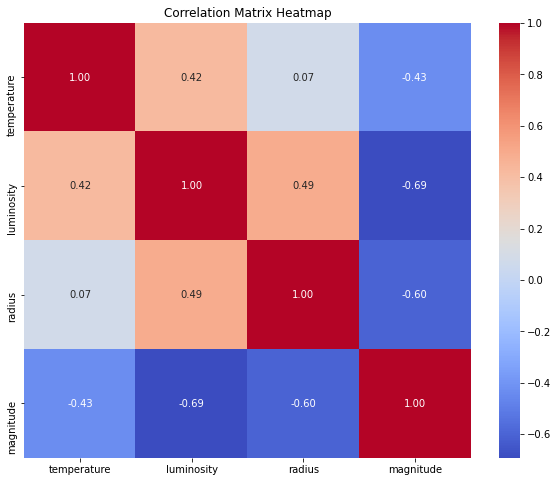

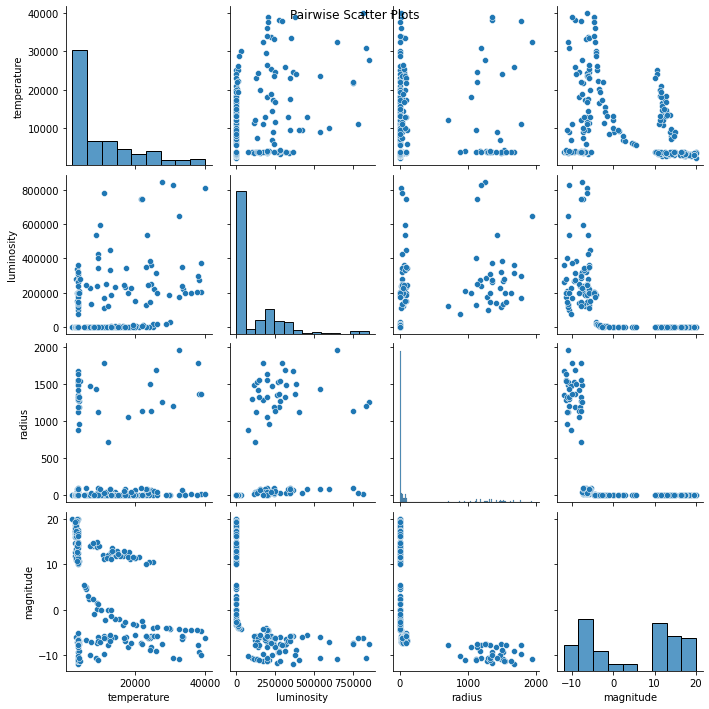

In [65]:
correlation_matrix = df[['temperature', 'luminosity', 'radius', 'magnitude']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix Heatmap')
plt.show()

sns.pairplot(df[['temperature', 'luminosity', 'radius', 'magnitude']])
plt.suptitle('Pairwise Scatter Plots')
plt.show()

Вывод
 - из матрицы корреляции можно сделать вывод, что светимость звезд сильно связана как с их радиусом, так и с абсолютной звездной величиной, в то время как температура имеет более слабую корреляцию с этими признаками.
 - из диаграммы рассеяния видим, что как правило более горячие, светимые и большие звёзды, являются наиболее яркими.

Проведем подготовку данных для дальнейшего обучения

In [66]:
numeric_features = ['luminosity', 'radius', 'magnitude']
categorical_features = ['color']

In [67]:
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_cols = pd.DataFrame(encoder.fit_transform(df[categorical_features]))
encoded_cols.columns = encoder.get_feature_names()
df = pd.concat([df, encoded_cols], axis=1)
df.drop(columns=categorical_features, inplace=True)

In [68]:
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [69]:
X = df.drop(columns=['temperature'])
y = df['temperature']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

Вывод:
 - В данных отсутвовали пропуски и дубликаты, исправлены неявные дубликаты в столбце 'color'
 - В столбце 'star_type' представлено одинаковое количество звезд в каждой из 6 категорий
 - Очевидных аномалий в количественных признаках не выявлено
 - Проведена подготовка данных для обучения: масштабирование, категоризация, разделение на обучающую и тестовую выборки
 

## Построение базовой нейронной сети

In [70]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [71]:
def rmse_loss(outputs, targets):
    mse_loss = nn.MSELoss()
    mse = mse_loss(outputs, targets)
    rmse = torch.sqrt(mse)
    return rmse

In [99]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons = 15
n_out_neurons = 1 

In [100]:
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons, n_out_neurons)
) 

In [101]:
loss = rmse_loss
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [102]:
def net_train(num_epochs, num_test):
    for epoch in range(num_epochs):
        net.train()
        optimizer.zero_grad()
        preds = net.forward(X_train).flatten()
        loss_value = loss(preds, y_train)
        loss_value.backward()
        optimizer.step()

        if epoch % num_test == 0 or epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test).flatten()
            test_loss = loss(test_preds, y_test)
            print(f'Epoch {epoch}, Test Loss: {test_loss.item()}')

In [103]:
num_epochs = 85000
num_test = 100
net_train(num_epochs, num_test)

Epoch 0, Test Loss: 13211.0888671875
Epoch 100, Test Loss: 13209.85546875
Epoch 200, Test Loss: 13207.23046875
Epoch 300, Test Loss: 13202.1484375
Epoch 400, Test Loss: 13194.6640625
Epoch 500, Test Loss: 13184.8046875
Epoch 600, Test Loss: 13172.673828125
Epoch 700, Test Loss: 13158.451171875
Epoch 800, Test Loss: 13142.2841796875
Epoch 900, Test Loss: 13124.27734375
Epoch 1000, Test Loss: 13104.5185546875
Epoch 1100, Test Loss: 13083.0859375
Epoch 1200, Test Loss: 13060.0498046875
Epoch 1300, Test Loss: 13035.4775390625
Epoch 1400, Test Loss: 13009.4287109375
Epoch 1500, Test Loss: 12981.9658203125
Epoch 1600, Test Loss: 12953.1435546875
Epoch 1700, Test Loss: 12923.0185546875
Epoch 1800, Test Loss: 12891.638671875
Epoch 1900, Test Loss: 12859.0556640625
Epoch 2000, Test Loss: 12825.31640625
Epoch 2100, Test Loss: 12790.46875
Epoch 2200, Test Loss: 12754.5546875
Epoch 2300, Test Loss: 12717.6171875
Epoch 2400, Test Loss: 12679.6923828125
Epoch 2500, Test Loss: 12640.822265625
Epoch 2

Добавим один внутренний слой и проверим результа


In [104]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 7
n_out_neurons = 1 

In [105]:
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
) 
loss = rmse_loss
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [106]:
num_epochs = 13000
num_test = 100
# num_epochs = 100000
# num_test = 5000
net_train(num_epochs, num_test)

Epoch 0, Test Loss: 13211.076171875
Epoch 100, Test Loss: 13209.07421875
Epoch 200, Test Loss: 13196.9599609375
Epoch 300, Test Loss: 13159.9921875
Epoch 400, Test Loss: 13085.09765625
Epoch 500, Test Loss: 12961.720703125
Epoch 600, Test Loss: 12783.3056640625
Epoch 700, Test Loss: 12545.9013671875
Epoch 800, Test Loss: 12249.392578125
Epoch 900, Test Loss: 11897.5986328125
Epoch 1000, Test Loss: 11497.0126953125
Epoch 1100, Test Loss: 11056.7744140625
Epoch 1200, Test Loss: 10591.5771484375
Epoch 1300, Test Loss: 10121.7314453125
Epoch 1400, Test Loss: 9669.65234375
Epoch 1500, Test Loss: 9257.3857421875
Epoch 1600, Test Loss: 8902.732421875
Epoch 1700, Test Loss: 8612.998046875
Epoch 1800, Test Loss: 8383.3466796875
Epoch 1900, Test Loss: 8200.6513671875
Epoch 2000, Test Loss: 8050.6357421875
Epoch 2100, Test Loss: 7922.1474609375
Epoch 2200, Test Loss: 7807.98486328125
Epoch 2300, Test Loss: 7704.08837890625
Epoch 2400, Test Loss: 7608.35107421875
Epoch 2500, Test Loss: 7519.514648

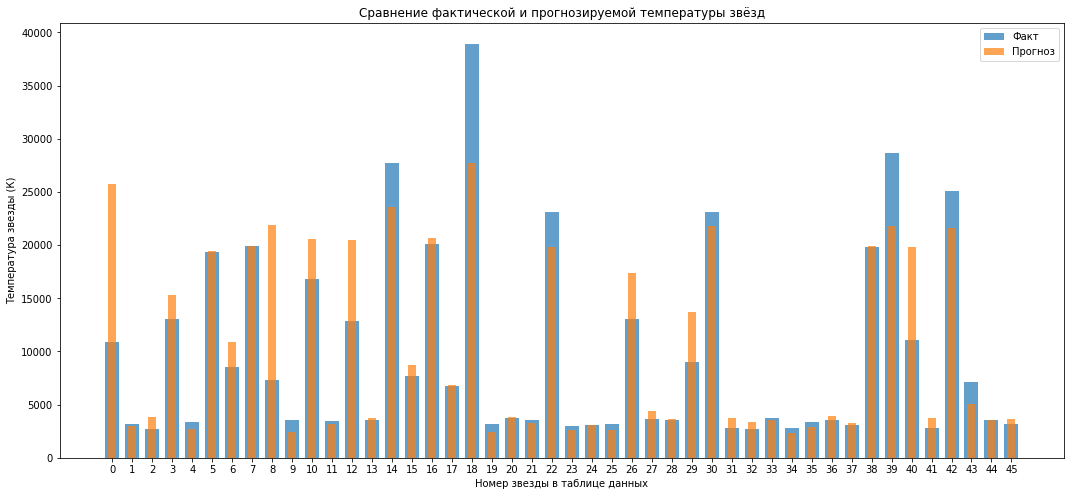

In [108]:
indices = np.arange(len(y_test))
test_preds = net.forward(X_test).flatten().detach().numpy()

fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(8)
ax.set_xticks(indices)
fact = ax.bar(indices, y_test.detach().numpy(), width=0.7, label='Факт', align='center', alpha=0.7)
forecast = ax.bar(indices, test_preds, width=0.4, label='Прогноз', align='center', alpha=0.7)
ax.legend()
ax.set_title('Сравнение фактической и прогнозируемой температуры звёзд')
ax.set_xlabel('Номер звезды в таблице данных')
ax.set_ylabel('Температура звезды (К)')
plt.show()

#### Вывод:
Было обучено две простых сети, первая с одним скрытым слоем, вторая с двумя. Обе сети показали хорошие результаты в районе 4300, но сеть с двумя слоями обучается гораздо быстре. Далее нам предстоит попробовать улучшить этот показазатель. Судя по графику факт-прогноз мы модель достаточно точно определяет температуру звезду, если ее значение лежить в диапазоне 5000(К). При более высокой температуре модель начинает ошибатся как в большую так и в меньшую стороны. Скороее всего это вызвано недостаточным объемем выборки.

## Улучшение нейронной сети

Добавим перебор параметров dropout_rate и batch_sizes для сети с двумя слоями.

In [110]:
dropout_rates = [0.1, 0.25, 0.5]
batch_sizes = [2, 8, 16]
num_epochs = 13000

In [111]:
def model_train(batch_size, num_epochs, model, X_train, y_train, X_test, y_test):
    num_batches = ceil(len(X_train)/batch_size)
    for epoch in range(num_epochs):
        model.train()
        order = np.random.permutation(len(X_train)) 
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size 
            optimizer.zero_grad()
            batch_indexes = order[start_index:start_index+batch_size] 
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            preds = model.forward(X_batch).flatten()
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
        if epoch % 100 == 0 or epoch == num_epochs - 1:
            model.eval()
            test_preds = model.forward(X_test)
            test_loss = loss(test_preds, y_test)
            print(f'Epoch {epoch}, Test Loss: {test_loss.item()}')

In [112]:
for dropout_rate, batch_size in itertools.product(dropout_rates, batch_sizes):
    model = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_2, n_out_neurons)
    )
    loss = rmse_loss
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    
    print(f"Training with dropout rate: {dropout_rate}, batch size: {batch_size}")
    model_train(batch_size, num_epochs, model,X_train, y_train, X_test, y_test)
    

Training with dropout rate: 0.1, batch size: 2
Epoch 0, Test Loss: 13008.12890625


/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100, Test Loss: 11779.8671875
Epoch 200, Test Loss: 11865.8701171875
Epoch 300, Test Loss: 12002.8740234375
Epoch 400, Test Loss: 11995.505859375
Epoch 500, Test Loss: 11897.1630859375
Epoch 600, Test Loss: 12256.9853515625
Epoch 700, Test Loss: 11948.80859375
Epoch 800, Test Loss: 12020.859375
Epoch 900, Test Loss: 11933.9375
Epoch 1000, Test Loss: 12284.685546875
Epoch 1100, Test Loss: 12265.9140625
Epoch 1200, Test Loss: 12695.9013671875
Epoch 1300, Test Loss: 12059.013671875
Epoch 1400, Test Loss: 11594.724609375
Epoch 1500, Test Loss: 11741.0224609375
Epoch 1600, Test Loss: 12010.1474609375
Epoch 1700, Test Loss: 12321.2685546875
Epoch 1800, Test Loss: 12408.166015625
Epoch 1900, Test Loss: 11909.8974609375
Epoch 2000, Test Loss: 12368.5810546875
Epoch 2100, Test Loss: 12437.8369140625
Epoch 2200, Test Loss: 11900.841796875
Epoch 2300, Test Loss: 12540.6298828125
Epoch 2400, Test Loss: 12452.5498046875
Epoch 2500, Test Loss: 12402.44921875
Epoch 2600, Test Loss: 12288.097656

Добавление параметров dropout_rate и batch_size показало гораздо худшие результаты (11000 - 12000) чем простые сети без дополнительных параметров

Попробуем добавить пакетную нормализацию.

In [119]:
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.BatchNorm1d(n_hidden_neurons_1),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.BatchNorm1d(n_hidden_neurons_2),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
) 
loss = rmse_loss
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [120]:
num_epochs = 13000
num_test = 100
net_train(num_epochs, num_test)

Epoch 0, Test Loss: 13211.3740234375
Epoch 100, Test Loss: 13193.05859375
Epoch 200, Test Loss: 13124.7158203125
Epoch 300, Test Loss: 13036.763671875
Epoch 400, Test Loss: 12910.3330078125
Epoch 500, Test Loss: 12423.3955078125
Epoch 600, Test Loss: 12294.6435546875
Epoch 700, Test Loss: 12095.6591796875
Epoch 800, Test Loss: 11750.751953125
Epoch 900, Test Loss: 11089.701171875
Epoch 1000, Test Loss: 10553.3330078125
Epoch 1100, Test Loss: 11441.4951171875
Epoch 1200, Test Loss: 9814.6796875
Epoch 1300, Test Loss: 8663.9013671875
Epoch 1400, Test Loss: 10085.74609375
Epoch 1500, Test Loss: 9390.4892578125
Epoch 1600, Test Loss: 8072.8740234375
Epoch 1700, Test Loss: 8157.6806640625
Epoch 1800, Test Loss: 6981.61083984375
Epoch 1900, Test Loss: 6834.96484375
Epoch 2000, Test Loss: 6418.22705078125
Epoch 2100, Test Loss: 6766.89794921875
Epoch 2200, Test Loss: 7127.73095703125
Epoch 2300, Test Loss: 5933.4365234375
Epoch 2400, Test Loss: 7101.7685546875
Epoch 2500, Test Loss: 6504.7055

Добавление только пакетной нормализации к простой сети не привелу к улучшению ни скорости обучения сети ни целевой метрики

Попробуем применить GridSearchCV и scroch

In [215]:
class RegressionNet(nn.Module):
    def __init__(self, n_hidden_neurons_1, n_hidden_neurons_2, dropout_rate):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, X):
        X = torch.relu(self.fc1(X))
        X = self.dropout1(X)
        X = torch.relu(self.fc2(X))
        X = self.dropout2(X)
        X = self.fc3(X)
        return X

In [216]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, y_pred, y_true):
        y_pred = y_pred.view_as(y_true)
        return torch.sqrt(self.mse(y_pred, y_true))

In [159]:
net = NeuralNetRegressor(
    module=RegressionNet,
    module__n_hidden_neurons_1=15,
    module__n_hidden_neurons_2=7,
    module__dropout_rate=0.5,  
    criterion=RMSELoss, 
    optimizer=optim.Adam,
    optimizer__lr=1e-3,
    max_epochs=1000,
)

In [160]:
params = {
    'lr': [0.01, 0.001],
    #'module__n_hidden_neurons_1': [10, 15, 20],
    #'module__n_hidden_neurons_2': [5, 7, 10],
    'module__dropout_rate': [0.0, 0.1, 0.25, 0.5],
    'batch_size': [16, 32, 64],
}

In [161]:
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='neg_mean_squared_error')

In [162]:
gs.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    14891.1707    18018.4152  0.0088
      2    14891.1392    18018.3826  0.0088
      3    14891.1050    18018.3480  0.0086
      4    14891.0674    18018.3095  0.0088
      5    14891.0256    18018.2676  0.0085
      6    14890.9818    18018.2225  0.0086
      7    14890.9316    18018.1643  0.0081
      8    14890.8768    18018.0988  0.0085
      9    14890.8148    18018.0211  0.0082
     10    14890.7453    18017.9354  0.0261
     11    14890.6650    18017.8341  0.0086
     12    14890.5758    18017.7205  0.0089
     13    14890.4749    18017.5911  0.0086
     14    14890.3628    18017.4448  0.0084
     15    14890.2358    18017.2789  0.0076
     16    14890.0926    18017.0888  0.0079
     17    14889.9299    18016.8700  0.0081
     18    14889.7438    18016.6205  0.0079
     19    14889.5324    18016.3351  0.0087
     20    14889.2920    18016.0099  0.0083
     21    14889.0218    18015.6

GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.RegressionNet'>,
  module__dropout_rate=0.5,
  module__n_hidden_neurons_1=15,
  module__n_hidden_neurons_2=7,
),
             param_grid={'batch_size': [16, 32, 64], 'lr': [0.01, 0.001],
                         'module__dropout_rate': [0.0, 0.1, 0.25, 0.5]},
             refit=False, scoring='neg_mean_squared_error')

In [200]:
print("Лучшие параметры:", gs.best_params_)

Лучшие параметры: {'batch_size': 16, 'lr': 0.01, 'module__dropout_rate': 0.1}


In [235]:
best_model = NeuralNetRegressor(
    module=RegressionNet,
    module__n_hidden_neurons_1=15,
    module__n_hidden_neurons_2=7,
    module__dropout_rate=gs.best_params_['module__dropout_rate'],
    optimizer=optim.Adam,
    optimizer__lr=gs.best_params_['lr'],
    criterion=RMSELoss,
    max_epochs=1,
    batch_size=gs.best_params_['batch_size']
)

Попробуем определить значение эпохи, для которой было бы лучшее значение метрики RMSE

In [237]:
best_rmse = float('inf')
best_epoch = 0

for epoch in range(1, 2500): 
    best_model.partial_fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    current_rmse = RMSELoss()(torch.tensor(y_pred), torch.tensor(y_test)).item()
    
    if current_rmse < best_rmse:
        best_rmse = current_rmse
        best_epoch = epoch
        torch.save(best_model.module_.state_dict(), 'best_model.pth')

      2    15263.4455    11713.1966  0.0153
      3    15258.1834    11705.2804  0.0141


/tmp/ipykernel_31/4060445679.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_rmse = RMSELoss()(torch.tensor(y_pred), torch.tensor(y_test)).item()


      4    15246.9420    11689.0904  0.0141
      5    15223.9992    11658.8421  0.0140
      6    15180.0083    11607.5019  0.0136
      7    15112.8044    11527.7617  0.0139
      8    15016.1541    11412.2223  0.0141
      9    14870.8204    11252.0764  0.0144
     10    14675.1123    11041.3960  0.0149
     11    14445.2495    10779.0382  0.0138
     12    14079.5089    10450.5026  0.0145
     13    13738.1752    10071.8700  0.0141
     14    13254.9491     9745.7592  0.0141
     15    13034.0831     9414.9706  0.0136
     16    12629.7841     9108.6746  0.0141
     17    12388.1586     8797.5876  0.0140
     18    12058.5375     8519.0476  0.0149
     19    11706.5492     8240.1161  0.0146
     20    11495.9461     7979.2460  0.0134
     21    11359.0036     7729.2249  0.0145
     22    11040.6037     7505.2720  0.0140
     23    10864.5456     7301.7993  0.0219
     24    10422.2175     7095.2207  0.0149
     25    10393.6556     6906.6144  0.0147
     26    10315.4945     6741.4

In [238]:
print(f'Лучшее значение RMSE: {best_rmse} достигнуто на эпохе {best_epoch}')

Лучшее значение RMSE: 4307.55908203125 достигнуто на эпохе 1376


Загрузим состояние сети для лучший метрики, чтобы построить график план-факт

In [250]:
model = NeuralNetRegressor(
    module=RegressionNet,
    module__n_hidden_neurons_1=15,
    module__n_hidden_neurons_2=7,
    module__dropout_rate=gs.best_params_['module__dropout_rate'],
)

In [251]:
model.initialize()
model.module_.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [252]:
model.module_.eval()

RegressionNet(
  (fc1): Linear(in_features=8, out_features=15, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=15, out_features=7, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=7, out_features=1, bias=True)
)

In [253]:
y_pred = model2.predict(X_test)
rmse = RMSELoss()(torch.tensor(y_pred), torch.tensor(y_test)).item()
print(f'RMSE: {rmse}')

RMSE: 4307.55908203125


/tmp/ipykernel_31/2205833425.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rmse = RMSELoss()(torch.tensor(y_pred), torch.tensor(y_test)).item()


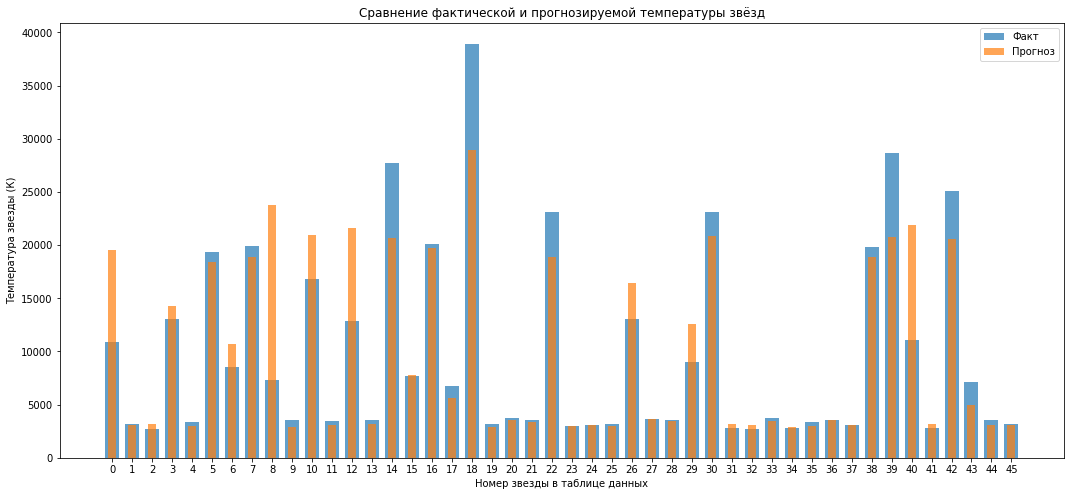

In [259]:
indices = np.arange(len(y_test))
test_preds = torch.tensor(y_pred).flatten()

fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(8)
ax.set_xticks(indices)
fact = ax.bar(indices, y_test.detach().numpy(), width=0.7, label='Факт', align='center', alpha=0.7)
forecast = ax.bar(indices, test_preds, width=0.4, label='Прогноз', align='center', alpha=0.7)
ax.legend()
ax.set_title('Сравнение фактической и прогнозируемой температуры звёзд')
ax.set_xlabel('Номер звезды в таблице данных')
ax.set_ylabel('Температура звезды (К)')
plt.show()

Применение GridSearch позволило незначительно улучшить метрику, но стоит учитывать, что метрика на валидации составляла 4514, что говорит о том, что сеть переобучена. Видно, что для некоторых звезд совпадение план-факта улучшилось, но принципиально не изменилось, из-за редких звезд с большой температурой.

## Выводы

Был обучено две простых модели с одной и двумя скрытыми слоями. Первая модель показала метрику RMSE 4331 на эпохе 80300, вторая показала метрику 4325 на эпохе 12999. Так же были предприняты следующие способы улучшений сети: перебор циклом параметров dropout_rate и batch_size, а также пакетная номрализация. Но это не дало улучшений. После чего был применен GridSearch для поиска оптимальных параметров, что позволило улучшить метрику до 4307, но учитывая что на валидации RMSE 4514, то сеть получилась немного переобученной.